# Forecast de Ventas 2026: Análisis por Tipo de Suscripción

**Objetivo:** Generar una proyección diaria de ventas (cantidad y/o ingresos) para el año 2026 basada en el histórico Agosto 2022 - Agosto 2025.

**Metodología:** Se utilizará el algoritmo **Prophet** (Meta), ideal para series de tiempo con fuerte estacionalidad y efectos de calendario.

**Datos de entrada:**
- Granularidad: Diaria
- Segmentación: `tipo_suscripcion`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# Configuración visual para los gráficos
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
plt.rcParams['figure.figsize'] = (15, 6)

print("Librerías cargadas correctamente.")

c:\Users\victor.briones\Documents\python_virtual_enviroments\exploratory_data_analysis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Librerías cargadas correctamente.


In [2]:
# 1. Cargar el dataset
# Asegúrate de que el archivo esté en la misma carpeta o coloca la ruta completa
anio = 2026
name_file = '7_dias' 
nombre_archivo = f'../data/data_forecast_{anio}/data_forecast_{anio}_silver/numero_membresia_{name_file}_limpio.csv'
print(f"Cargando el archivo: {nombre_archivo}")  # <--- CAMBIA ESTO POR TU ARCHIVO REAL
df_main = pd.read_csv(nombre_archivo)

# 2. Conversión de fechas
df_main['fecha'] = pd.to_datetime(df_main['fecha'])

# 3. Verificación rápida
print(f"Rango de fechas: {df_main['fecha'].min()} a {df_main['fecha'].max()}")

display(df_main.head())

Cargando el archivo: ../data/data_forecast_2026/data_forecast_2026_silver/numero_membresia_7_dias_limpio.csv
Rango de fechas: 2022-07-27 00:00:00 a 2025-11-30 00:00:00


,cantidad_Vendida,ingresos_totales_reales,fecha,cantidad_Vendida_imputado
0,1,391.0,2022-07-27,1.0
1,1,391.0,2022-07-31,1.0
2,1,391.0,2022-08-09,1.0
3,6,2346.0,2022-08-13,6.0
4,5,1955.0,2022-08-14,5.0


In [3]:
df_main.describe()

,cantidad_Vendida,ingresos_totales_reales,fecha,cantidad_Vendida_imputado
count,1202.000000,1202.000000,1202,1202.000000
mean,12.531614,5044.926705,2024-04-08 04:30:44.925124864,11.322795
min,1.000000,391.000000,2022-07-27 00:00:00,1.000000
25%,7.000000,2737.000000,2023-06-13 06:00:00,7.000000
50%,11.000000,4301.000000,2024-04-08 12:00:00,11.000000
75%,16.000000,6375.000000,2025-02-02 18:00:00,15.000000
max,66.000000,25806.000000,2025-11-30 00:00:00,29.000000
std,8.102553,3269.562094,NaN,5.794622


Filtro para obtener muestra de datos

In [4]:
# *** PASO CRÍTICO: RENOMBRAR COLUMNAS ***
# Supongamos que tu csv tiene 'Fecha_Venta' y 'Total_Vendido'
df = df_main.rename(columns={'fecha': 'ds', 'cantidad_Vendida_imputado': 'y'})

# Asegurar que 'ds' sea datetime
df['ds'] = pd.to_datetime(df['ds'])

Paso 3: Configurar y Entrenar el Modelo
- Aquí instanciamos la clase Prophet. Puedes agregar configuraciones extra aquí (como festivos).

Nota: Usé seasonality_mode='multiplicative' porque en ventas, cuando la tendencia crece, la estacionalidad suele crecer proporcionalmente (vendes más en Navidad año con año si tu empresa crece).

In [5]:
""" # Inicializar el modelo
# daily_seasonality=True si tienes datos por hora/minuto, si es por día, Prophet lo detecta solo.
m = Prophet(seasonality_mode='multiplicative') 

# Añadir festivos (Opcional pero recomendado para ventas)
m.add_country_holidays(country_name='MX') # Código de país (ej. MX, US, ES)

# Entrenar el modelo (Ajustar a los datos históricos)
m.fit(df) """
df['cap'] = 30

# 2. Configurar el modelo con crecimiento logístico
m = Prophet(
            changepoint_prior_scale=0.2,  # Hacemos la tendencia más flexible (detecta cambios rápidos)
            seasonality_prior_scale=20.0,  # Damos más peso a la estacionalidad
            daily_seasonality=False,       # Apagamos estacionalidad diaria si solo tenemos datos por día
            #########
            growth='logistic', 
            seasonality_mode='multiplicative',
            yearly_seasonality=True)

m.add_country_holidays(country_name='MX')
m.fit(df)


17:10:06 - cmdstanpy - INFO - Chain [1] start processing
17:10:06 - cmdstanpy - INFO - Chain [1] done processing


Paso 4: Crear el DataFrame Futuro
- Necesitamos crear una tabla vacía con las fechas futuras que queremos predecir.

In [6]:
# Crear fechas futuras para 365 días (1 año)
future = m.make_future_dataframe(periods=365)
future['cap'] = 30

# Ver las últimas filas para confirmar que llegamos al futuro
print(future.tail())

             ds  cap
1562 2026-11-26   30
1563 2026-11-27   30
1564 2026-11-28   30
1565 2026-11-29   30
1566 2026-11-30   30


Paso 5: Realizar la Predicción (Forecast)

In [7]:
# Predecir
forecast = m.predict(future)

# El resultado 'forecast' es un dataframe con muchas columnas.
# Nos interesan: 'ds', 'yhat' (predicción), 'yhat_lower' y 'yhat_upper' (intervalos de confianza)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

             ds       yhat  yhat_lower  yhat_upper
1562 2026-11-26  10.266913    4.201284   16.471028
1563 2026-11-27   9.869738    3.714723   16.320866
1564 2026-11-28  11.462945    5.255972   17.760673
1565 2026-11-29  13.821203    8.131032   20.139059
1566 2026-11-30  10.133098    3.849825   16.400528


Paso 6: Visualización
- Prophet tiene herramientas de visualización integradas que son excelentes.

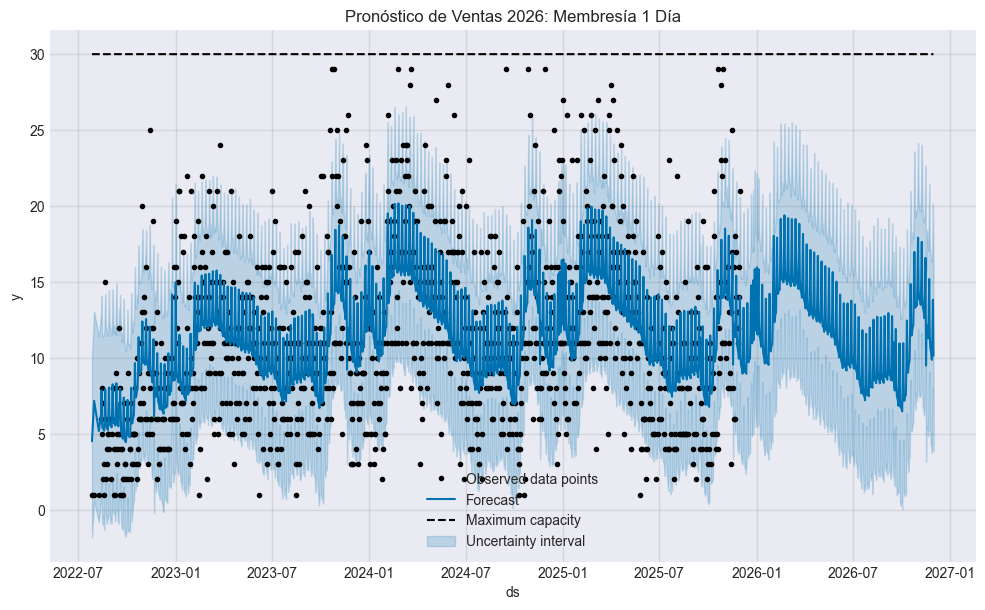

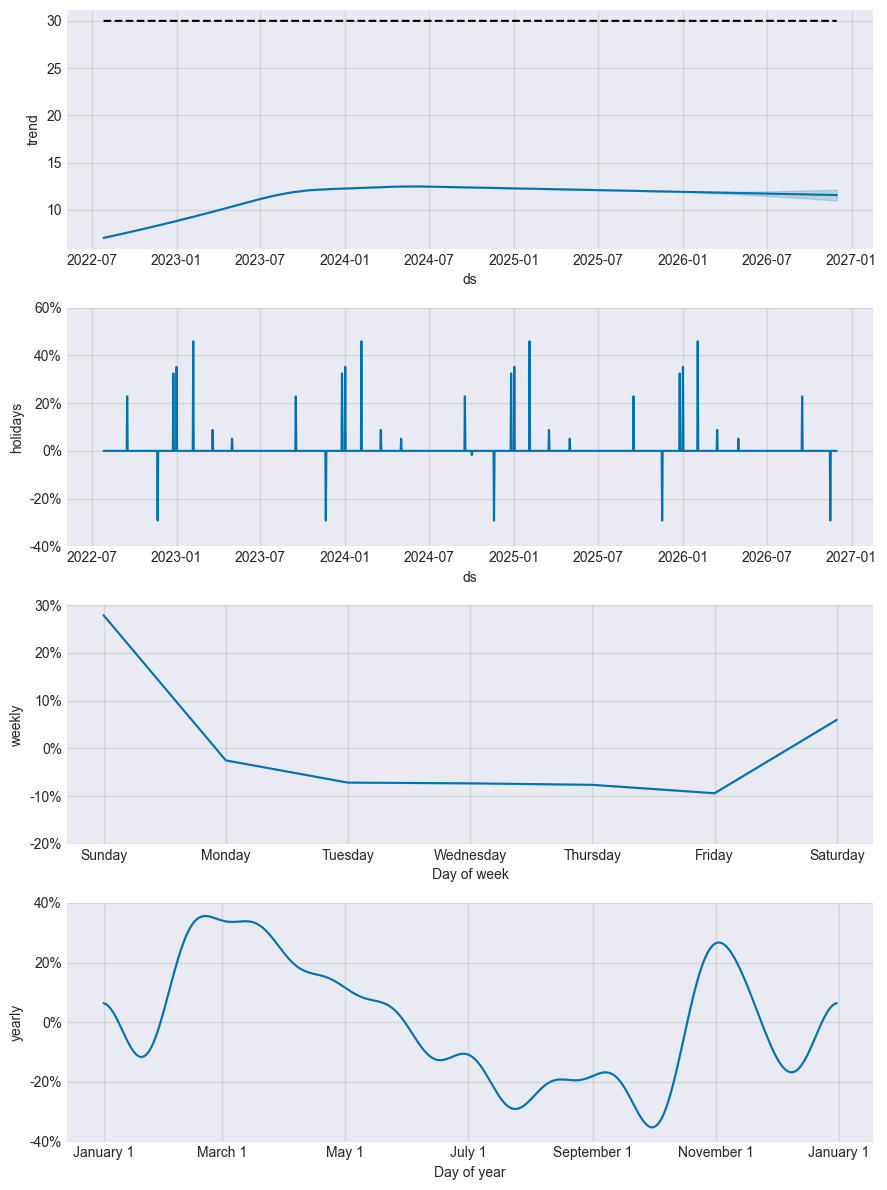

In [8]:
# 1. Gráfico principal: Puntos negros son datos reales, línea azul es la predicción
fig1 = m.plot(forecast)
plt.title("Pronóstico de Ventas 2026: Membresía 1 Día")
# mostrar leyenda
plt.legend()
plt.show()

# 2. Desglose de componentes: Muestra Tendencia, Semanal, Anual y Festivos por separado
fig2 = m.plot_components(forecast)
plt.show()

##### Agrupamos data por mes para su exportacion

In [9]:
# agrupar por mes y sumar yhat, yhat_lower, yhat_upper
forecast['ds'] = pd.to_datetime(forecast['ds'])
forecast['month'] = forecast['ds'].dt.to_period('M')
monthly_sales = forecast.groupby('month')[['yhat', 'yhat_lower', 'yhat_upper']].sum().round(0).reset_index()
print(monthly_sales)

      month   yhat  yhat_lower  yhat_upper
0   2022-07   12.0        -1.0        23.0
1   2022-08  108.0        -1.0       221.0
2   2022-09  165.0        -6.0       338.0
3   2022-10  226.0        49.0       402.0
4   2022-11  275.0        88.0       461.0
5   2022-12  241.0        56.0       429.0
6   2023-01  274.0        85.0       465.0
7   2023-02  340.0       168.0       514.0
8   2023-03  397.0       203.0       588.0
9   2023-04  359.0       176.0       544.0
10  2023-05  348.0       161.0       538.0
11  2023-06  295.0       110.0       480.0
12  2023-07  278.0        88.0       468.0
13  2023-08  285.0        94.0       476.0
14  2023-09  277.0        92.0       462.0
15  2023-10  354.0       163.0       541.0
16  2023-11  406.0       222.0       590.0
17  2023-12  356.0       165.0       549.0
18  2024-01  370.0       181.0       562.0
19  2024-02  462.0       285.0       642.0
20  2024-03  510.0       318.0       703.0
21  2024-04  434.0       250.0       618.0
22  2024-05

In [10]:
monthly_sales.to_csv(f"../data/data_forecast_{anio}/data_forecast_{anio}_gold/forecast_numero_{name_file}_{anio}_monthly.csv")

In [11]:
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='90 days')

# 2. Calcular métricas de error
df_p = performance_metrics(df_cv)

# 3. Ver el resultado (Las métricas más importantes)
print(df_p[['horizon', 'rmse', 'mape']].head())

  0%|          | 0/3 [00:00<?, ?it/s]17:10:09 - cmdstanpy - INFO - Chain [1] start processing
17:10:09 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:01,  1.27it/s]17:10:10 - cmdstanpy - INFO - Chain [1] start processing
17:10:10 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:01<00:01,  1.02s/it]17:10:11 - cmdstanpy - INFO - Chain [1] start processing
17:10:12 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

  horizon      rmse      mape
0  9 days  5.687493  0.642628
1 10 days  5.726073  0.587850
2 11 days  5.833518  0.574027
3 12 days  5.515467  0.521540
4 13 days  5.109423  0.455571
